In [1]:
import numpy as np
import torch
import torchvision

import torchvision.transforms as transforms
from datasets import SynthDataset
from synth_utils import js_div, kl_div, pca
from priors import FactorizedNormalPrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

Processing...
Done!


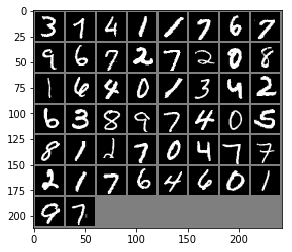

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN-NG

In [126]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [127]:
trainset[0][0].size()

torch.Size([1, 28, 28])

In [128]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

class GeneratorNetwork(nn.Module):
    
    def __init__(self, shape, num_samples):
        super(GeneratorNetwork, self).__init__()
        self.build_net(shape, num_samples)
        self.output_dim = shape
    
    def build_net(self, shape, num_samples):
        z = torch.from_numpy(np.random.normal(size=[num_samples] + shape)).float()
        self.z_v = Variable(z, requires_grad=True)
    
    
    def forward(self):
        output = self.z_v
        return output
    
    def parameters(self):
        return [self.z_v]

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, K):
        super(DiscriminatorNetwork, self).__init__()
        self.build_net(K)
        self.K = K
    
    def build_net(self, K):
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(256, K)
    
    def forward(self, input):
        x = F.max_pool2d(F.relu(self.conv1(input)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = F.softmax(x)
        return x
    
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [129]:
class FixedSizeDataset(torch.utils.data.Dataset):
    
    def __init__(self, maxlen):
        self.elems = []
        self.maxlen = maxlen
        
    def __getitem__(self, index):
        return self.elems[index]
    
    def append(self, elem):
        self.elems.append(elem)
        if len(self) > self.maxlen:
            self.elems = self.elems[1:]
    
    def __len__(self):
        return len(self.elems)

In [130]:
class BGAN:
    
    def __init__(self, generator, generator_prior, discriminator, num_data, eta=2e-4, alpha=0.01, max_fake=10000,
                disc_lr=1e-3):
        """
        Bayesian GAN with no generator
        """
        super(BGAN, self).__init__()
        
        self.discriminator = discriminator
        self.generator = generator
        
        self.eta = eta
        self.alpha = alpha
        self.num_data = num_data
        self.disc_lr = disc_lr
        self.generator_prior = generator_prior
            
        self.K = discriminator.K
        self._init_optimizers()
        self.fake_dataset = FixedSizeDataset(max_fake)
        self.fake_dataset.append(np.copy(self.generator.forward().data.numpy())[0, :])
        self.fake_batch_loader = torch.utils.data.DataLoader(self.fake_dataset, 
                                                            batch_size=64, shuffle=True)
        self.fake_batch_generator = self.get_fake_batch()
        
    def get_fake_batch(self):
        while True:
            for batch in self.fake_batch_loader:
                yield Variable(batch.float())
            
    def loss(self, x_batch):
        batch_size = x_batch.size()[0]
        fake_batch = next(self.fake_batch_generator)
        x_gen = self.generator.forward()
        x_real = x_batch
        
        
        d_logits_real = self.discriminator(x_real)[:, 0]
        d_logits_fake = self.discriminator(fake_batch)[:, 0]
        d_logits_gen = self.discriminator(x_gen)[:, 0]
        
        y_real = Variable(torch.ones(batch_size))
        y_fake = Variable(torch.zeros(fake_batch.size()[0]))
        y_gen = Variable(torch.zeros(x_gen.size()[0]))
        
        bce = nn.BCELoss()
        bce_real = bce(d_logits_real, y_real)
        bce_fake = bce(d_logits_fake, y_fake)
        bce_gen = bce(d_logits_gen, y_gen)
        noise_std = np.sqrt(2 * self.alpha * self.eta)
        
        d_loss = -(bce_real + bce_fake) * self.disc_lr
        d_loss *= -1.
        
        #generator loss
        g_loss = torch.sum(torch.log(d_logits_gen[0])) * self.eta
        g_loss -= torch.sum(1 - torch.log(d_logits_gen[0])) * self.eta
        g_loss += self.noise(self.generator, noise_std)
        g_loss += (self.generator_prior.log_density(self.generator)
                      * self.eta)
        g_loss *= -1.
        self.d_loss_fake = (bce_fake).data.numpy()[0]
        self.d_loss_real = bce_real.data.numpy()[0]
        return d_loss, g_loss
        
    @staticmethod
    def noise(model, std):
        """
        Multiplies all the variables by a normal rv for SGHMC.
        """
        loss = 0
        for param in model.parameters():
            n = Variable(torch.normal(0, std=std*torch.ones(param.size())))
            loss += torch.sum(n * param)
        return loss
    
    def _init_optimizers(self):
        self.d_optimizer = optim.SGD(self.discriminator.parameters(), lr=1, momentum=(1 - self.alpha))
        self.g_optimizer = optim.SGD(self.generator.parameters(), lr=1, momentum=(1 - self.alpha))
        
    
    def step(self, x_batch):
        
        batchv = Variable(batch)
        self.discriminator.zero_grad()
        self.generator.zero_grad()
        d_loss, g_loss = self.loss(batchv)
        d_loss.backward(retain_graph=True)
        self.d_optimizer.step()
        
        g_loss.backward()
        self.g_optimizer.step()     
        

In [131]:
batch_size = 50

In [132]:
prior = FactorizedNormalPrior(std=5.)
disc = DiscriminatorNetwork(2)
gen = GeneratorNetwork([1, 28, 28], 1)
gen.apply(weights_init)
disc.apply(weights_init)
bgan = BGAN(gen, prior, disc, alpha=.01, eta=1e-5, num_data=len(trainset), disc_lr=1e-4)
samples = []

In [ ]:
old_samples = None
if isinstance(samples, np.ndarray):
    old_samples = np.copy(samples)
    samples = []
for epoch in range(20):
    for i, data_ in enumerate(trainloader, 0):
        batch = data_[0].float()
        bgan.step(batch)
        
        if not i%100:
            bgan.fake_dataset.append(np.copy(gen.z_v.data.numpy()[0, :]))
    if not epoch%1:
        samples.append(np.copy(gen.z_v.data.numpy()))
    if not epoch%1:
        print(epoch)
        print(bgan.d_loss_fake)
        print(bgan.d_loss_real)
if old_samples is not None:
    samples = np.vstack([old_samples, np.array(samples)])
else:
    samples = np.array(samples)

0
5.60542e-09
4.37999e-06
1
5.81545e-12
8.78271e-06
2
4.50191e-09
2.46051e-06
3
1.79305e-10
4.3775e-06
4
1.77826e-09
1.25766e-06
5
3.958e-12
2.93619e-06
6
9.24059e-07
1.05143e-06
7
6.80246e-11
3.47148e-06
8
1.138e-07
3.1556e-06
9
5.29452e-08
2.45693e-06
10
8.42229e-09
1.63675e-06
11
3.65586e-12
2.48912e-06


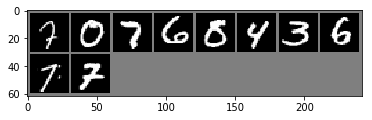

In [206]:
imshow(torchvision.utils.make_grid(batch[:10]))

In [207]:
fake_samples = []
for sample in bgan.fake_dataset:
    fake_samples.append(sample)
fake_samples = np.array(fake_samples)

In [208]:
samples = [np.array(sample).reshape((1, 1, 28, 28)) for sample in samples]

In [209]:
samples_arr = np.vstack(samples)

In [210]:
samples_arr.shape

(50, 1, 28, 28)

In [214]:
samples_arr.shape

(50, 1, 28, 28)

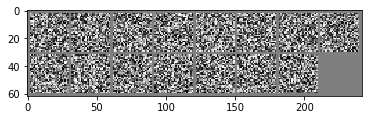

In [212]:
imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[-15:])))

In [215]:
sample_probs = disc(Variable(torch.from_numpy(samples_arr).float()))[:, 0].data.numpy()

In [217]:
sample_probs

array([  3.85901130e-14,   6.11891704e-17,   2.74578076e-18,
         7.82369861e-19,   1.50641873e-18,   9.84783157e-21,
         9.79127423e-20,   6.41129453e-18,   1.76155903e-17,
         1.53065587e-17,   9.29762232e-16,   1.77355445e-13,
         3.75775799e-14,   5.61486494e-16,   2.73803332e-12,
         2.70742127e-11,   1.79452408e-11,   3.54266699e-10,
         3.56878829e-08,   3.81499138e-10,   4.29759756e-10,
         3.74984888e-09,   7.25439930e-10,   1.58666580e-09,
         8.31683344e-09,   4.21426165e-08,   4.63933219e-07,
         1.27245497e-04,   2.15541921e-04,   1.25057442e-04,
         1.39914130e-06,   6.01844022e-07,   2.32010304e-08,
         8.82616291e-07,   3.24551524e-06,   7.37064241e-08,
         1.29241355e-08,   1.75327919e-10,   2.46327829e-07,
         5.00933410e-08,   1.34344313e-09,   3.75605831e-11,
         3.29285037e-11,   7.27681804e-11,   6.41628070e-12,
         8.62019900e-11,   2.72563742e-12,   5.04620179e-10,
         6.68531541e-08,

In [220]:
disc(Variable(batch))[:, 0]

Variable containing:
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
[torch.FloatTensor of size 50]

In [60]:
idx = np.where(sample_probs > 0.5)
good_samples = samples[idx]

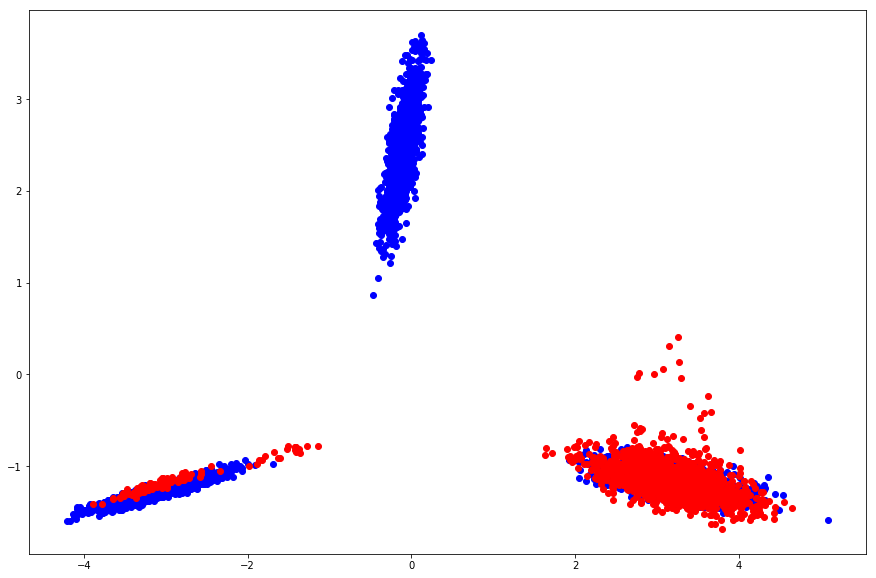

In [61]:
plt.figure(figsize=(15, 10))
x_r, x_f = pca(data.X.numpy(), good_samples)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_f[:, 0], x_f[:, 1], 'ro')
# plt.plot(x_f[-1, 0], x_f[-1, 1], 'ro', markersize=10)

In [62]:
true_probs = disc(Variable(data.X))[:, 0].data.numpy()
np.min(true_probs)

0.29538473

In [63]:
bad_idx = np.where(true_probs < 0.5)
bad_data = data.X.numpy()[bad_idx]

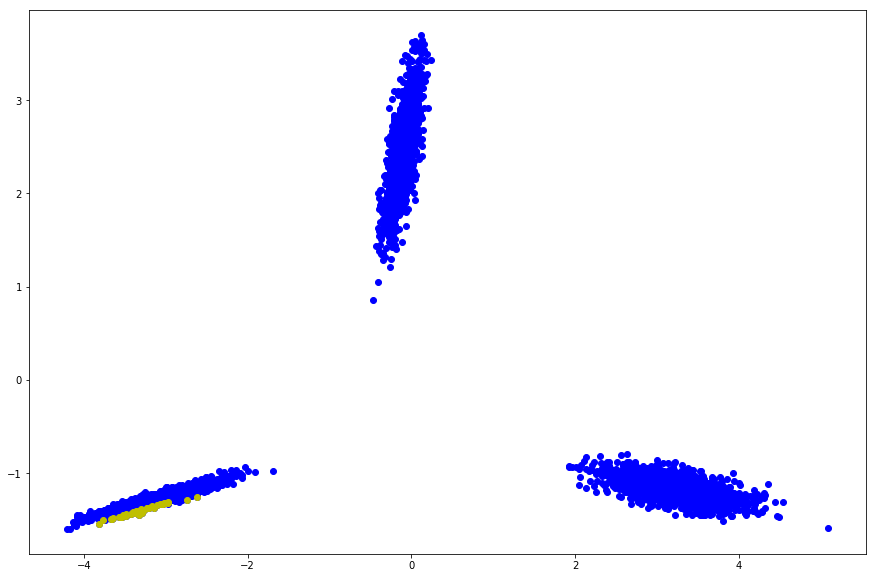

In [64]:
plt.figure(figsize=(15, 10))
x_r, x_b = pca(data.X.numpy(), bad_data)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_b[:, 0], x_b[:, 1], 'yo')